
cpu

***[INFO] Testing Epochs
[INFO] Epoch: 10

[INFO] Training model for 10 epochs

	[INFO] Epoch 1/10

		Accuracy of the model on the train images: 52.22 %
		Loss of the model on the train images: 109.29


		Accuracy of the model on the test images: 54.56 %
		Loss of the model on the test images: 27.73

		Loss: 1.06
		Train Accuracy: 52.22 %
		Test Loss: 27.73
		Test Accuracy: 54.56 %
		Curr Time: 2.19

	[INFO] Epoch 2/10

		Accuracy of the model on the train images: 58.19 %
		Loss of the model on the train images: 104.34


		Accuracy of the model on the test images: 56.56 %
		Loss of the model on the test images: 26.92

		Loss: 0.98
		Train Accuracy: 58.19 %
		Test Loss: 26.92
		Test Accuracy: 56.56 %
		Curr Time: 5.26

	[INFO] Epoch 3/10

		Accuracy of the model on the train images: 57.25 %
		Loss of the model on the train images: 104.13


		Accuracy of the model on the test images: 53.22 %
		Loss of the model on the test images: 27.72

		Loss: 0.95
		Train Accuracy: 57.25 %
		Tes

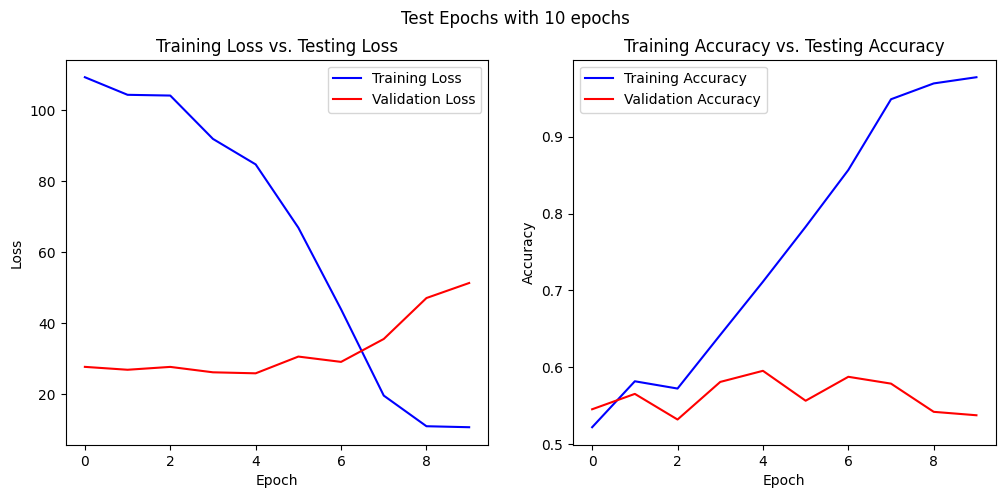

[INFO] Epoch: 15

[INFO] Training model for 15 epochs

	[INFO] Epoch 1/15

		Accuracy of the model on the train images: 51.72 %
		Loss of the model on the train images: 113.00


		Accuracy of the model on the test images: 48.22 %
		Loss of the model on the test images: 29.21

		Loss: 1.06
		Train Accuracy: 51.72 %
		Test Loss: 29.21
		Test Accuracy: 48.22 %
		Curr Time: 2.09

	[INFO] Epoch 2/15

		Accuracy of the model on the train images: 54.58 %
		Loss of the model on the train images: 104.85


		Accuracy of the model on the test images: 50.00 %
		Loss of the model on the test images: 27.65

		Loss: 0.97
		Train Accuracy: 54.58 %
		Test Loss: 27.65
		Test Accuracy: 50.00 %
		Curr Time: 4.97

	[INFO] Epoch 3/15

		Accuracy of the model on the train images: 55.58 %
		Loss of the model on the train images: 115.13


		Accuracy of the model on the test images: 51.00 %
		Loss of the model on the test images: 32.90

		Loss: 0.92
		Train Accuracy: 55.58 %
		Test Loss: 32.90
		Test Accuracy: 

KeyboardInterrupt: 

In [1]:
# from google.colab import drive
import zipfile
import torch

print()

if torch.cuda.is_available():
  device = torch.device("cuda:0")
#   drive.mount('/content/drive')
  with zipfile.ZipFile('/content/drive/MyDrive/UNI/traindata.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')
  pathToAll = '/content/data/traindata'
else: 
  device = torch.device("cpu")
  pathToAll = './traindata'

print(device)


from torch.nn.modules.normalization import LocalResponseNorm
import torch.nn as nn
from torchvision.transforms import transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import PCA
import time

class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def preprocessing(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224,224)), # Scaling the image to 224 x 224
        transforms.ToTensor(), # Converting the image to tensor
        transforms.Normalize(mean=[0.5474, 0.4110, 0.3390], std=[0.2267, 0.2350, 0.2272]) # Normalizing the image
    ])

    all_datasets = dsets.ImageFolder(pathToAll, transform = transform)

    train_size = int(len(all_datasets) * 0.8)
    test_size = int(len(all_datasets) * 0.2)

    train_data, test_data = random_split(all_datasets, [train_size, test_size])

    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

    return train_loader, test_loader

def train_model(cnn, train, test, criterion, optimizer, iters, title):
    print()
    print(f'[INFO] Training model for {iters} epochs')

    start_time = time.time()

    training_losses_history = []
    test_losses_history = []
    training_accu_history = []
    test_accu_history = []

    for epoch in range(iters):
        print()
        print(f'\t[INFO] Epoch {epoch+1}/{iters}')
        running_loss = 0.0

        for i, (images, labels) in enumerate(train, 0):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        current_time = (time.time() - start_time)/60
        total_loss = running_loss/len(train)

        curr_loss, curr_accur = evaluate_model(cnn, train, criterion, "train")
        curr_test_loss, curr_test_accur = evaluate_model(cnn, test, criterion, "test")

        training_losses_history.append(curr_loss)
        training_accu_history.append(curr_accur)
        test_losses_history.append(curr_test_loss)
        test_accu_history.append(curr_test_accur)

        curr_accur *= 100
        curr_test_accur *= 100

        print(f'\t\tLoss: {total_loss:.2f}')
        print(f'\t\tTrain Accuracy: {curr_accur:.2f} %')
        print(f'\t\tTest Loss: {curr_test_loss:.2f}')
        print(f'\t\tTest Accuracy: {curr_test_accur:.2f} %')
        print(f'\t\tCurr Time: {current_time:.2f} mins')

    end_time = (time.time()-start_time)/60
    print(f'[INFO] Finished Training at {end_time:.2f}' )

    plot_graphs(training_losses_history, test_losses_history, training_accu_history, test_accu_history, title)

def evaluate_model(cnn, datas, criterion, title):
    correct = 0
    total = 0
    runningloss = 0.0

    with torch.no_grad():
        for images, labels in datas:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            runningloss += loss.item()

    accuracy = correct / total
    print_accuracy = accuracy * 100
    totalLoss = runningloss

    print()
    print(f'\t\tAccuracy of the model on the {title} images: {print_accuracy:.2f} %')
    print(f'\t\tLoss of the model on the {title} images: {totalLoss:.2f}')
    print()

    return runningloss, accuracy

def plot_graphs(training_losses_history, test_losses_history, training_accu_history, test_accu_history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(training_losses_history, label='Training Loss', color='blue')
    ax1.plot(test_losses_history, label='Validation Loss', color='red')
    ax1.set_title('Training Loss vs. Testing Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(training_accu_history, label='Training Accuracy', color='blue')
    ax2.plot(test_accu_history, label='Validation Accuracy', color='red')
    ax2.set_title('Training Accuracy vs. Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.suptitle(title)

    plt.show()

def run():

    batch_sizes = [16, 32, 64, 100]
    # batch_sizes = [32]

    all_iters = [10, 15, 20, 25]
    # all_iters = [10]

    all_optimizers = [optim.SGD, optim.Adam, optim.RMSprop]  
    all_lr = [0.01, 0.02, 0.04]
    all_momentum = [0.009, 0.09, 0.9]

    print()
    print(f'***[INFO] Testing Epochs')
    for epoch in all_iters:
      print(f'[INFO] Epoch: {epoch}')
      tain_loader, test_loader = preprocessing(batch_size = 32)
      model = CNN_model()
      model = model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      train_model(model, tain_loader, test_loader, criterion, optimizer, epoch, f'Test Epochs with {epoch} epochs')

    print()
    print(f'***[INFO] Testing Batch')
    for batch in batch_sizes:
      print(f'[INFO] Batch: {batch}')
      tain_loader, test_loader = preprocessing(batch_size = batch)
      model = CNN_model()
      model = model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      train_model(model, tain_loader, test_loader, criterion, optimizer, 15, f'Test Batchs with {batch} batches')

    print()
    print(f'***[INFO] Testing Optimizers')
    for opti in all_optimizers:
      print()
      
      print(f'***[INFO] Testing LR for Optimizer: {opti}')
      for i in all_lr:
        print(f'\t[INFO] LR: {i}')
        tain_loader, test_loader = preprocessing(batch_size = 32)
        model = CNN_model()
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opti(model.parameters(), lr=i, momentum=0.9)
        train_model(model, tain_loader, test_loader, criterion, optimizer, 15, f'Test LR with {i} LR')

      print(f'***[INFO] Testing Momentum on Optimizer {opti}')
      for m in all_momentum:
        print(f'\t[INFO] Testing momentum: {m}')
        tain_loader, test_loader = preprocessing(batch_size = 32)
        model = CNN_model()
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opti(model.parameters(), lr=0.01, momentum=m)
        train_model(model, tain_loader, test_loader, criterion, optimizer, 15, f'Test momentum with {m} momentum')

run()
